# Part 1: Modeling Challenge

## i) Python Coding and Data Set

### Load in the data file, load in the header file and attach it to the dataframe

In [648]:
import os
import copy

import numpy as np
import pandas as pd

from sklearn import preprocessing
import scipy.stats as stats
from scipy.stats import ranksums
from scipy.stats import ttest_ind
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.linear_model import LogisticRegressionCV
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
#from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns

In [497]:
#Changing working directory to where the input and output files are saved
folder_path = 'C:/Users/Chen/Documents/DS Projects/DS Instructor'
working_dir = os.chdir(folder_path)

In [498]:
#Loading input files
df_colhead = pd.read_csv('field_names.txt',header=None)
df_cancer = pd.read_csv('breast-cancer.csv',header=None)
#reassign header for df_cancer using first column values of df_colhead
df_cancer.columns=df_colhead.iloc[:,0]

### Comment on any steps you might take to evaluate or transform the dataset.

Garbage in garbage out, so ensuring that the data is good quality is an important first step. Two common mays that may contribute to bad quality data are 
1. Missing data points. For instance, if the recording files are corrupted.
2. Not missing but erroneous data points. Outliers are a good indication of this.

Lastly, since most of the machine learning algorithms do not work well with missing data points, and so we need to impute them back.

There are various ways to do it (mean, median, EM-algorithm, KNN), but the main takeaway is that the imputated dataset should still retain the same distribution as the non-imputed data.

In [601]:
#Check for missing data
print('Is there any data that are missing:')
print(str(df_cancer.isna().values.any()))
print(str(df_cancer.isnull().values.any()))

Is there any data that are missing:
False
False


In [585]:
#Check for any outliers, some of which might due to bad data quality. 
#If left untreated, outliers may disporportionally attribute to model parameters and thus causing model errors.

#Make a copy of the original to contrast against the dataset with outlier removed
x_original = copy.deepcopy(df_cancer.iloc[:,2:]) 

#Outlier = |Z score| > 3, or 99.7% percentile under normal distribution
scaler = preprocessing.scale
x_scaled = abs(x.apply(lambda x: scaler(x)))

#Remove outliers, and then use KNN to impute back the value using the 5 nearest rows
df_cancer.iloc[:,2:][x_scaled>3] = np.nan

imputer = KNNImputer(n_neighbors=2)
df_cancer.iloc[:,2:] = imputer.fit_transform(df_cancer.iloc[:,2:])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


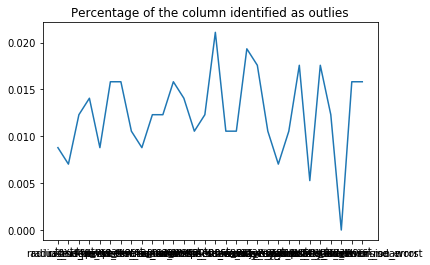

In [609]:
#<2% in any one column are identified as outliers and removed,
x_NOutlier = (x_scaled>3).astype(int)
P_outlier = x_NOutlier.sum(axis=0)/x.shape[0]
plt.title('Percentage of the column identified as outlies')
plt.plot(P_outlier)
plt.xlabel('')

#no change in overall distribution of the columns by Kolmogorov-Smirnov test
x_kstest = [stats.ks_2samp(x.iloc[:,1],x1.iloc[:,1]).pvalue for col in range(x.shape[1])]
print(x_kstest)

### Compute the mean and median smoothness and compactness for benign and malignant tumors - do they differ? Explain how you would identify this.

Hypothesis testing for mean and median are usually done using t-test and ranksum test. 

We use unpaired test, since smoothness and compacness are measured independently for benign and malignant tumors.

In [650]:
c_smooth = df_cancer.smoothness_mean
c_compact = df_cancer.compactness_mean
i_M = df_cancer['diagnosis']=='M'
i_B = df_cancer['diagnosis']=='B'

print('[Smoothness, compactness] Mean for benign: ' + str(df_cancer[i_B][['smoothness_mean','compactness_mean']].mean(axis=0).values))
print('[Smoothness, compactness] Mean for malignant: ' + str(df_cancer[i_M][['smoothness_mean','compactness_mean']].mean(axis=0).values))
print('[Smoothness, compactness] Median for benign: ' + str(df_cancer[i_B][['smoothness_mean','compactness_mean']].median(axis=0).values))
print('[Smoothness, compactness] Median for malignant: ' + str(df_cancer[i_M][['smoothness_mean','compactness_mean']].median(axis=0).values))

[Smoothness, compactness] Mean for benign: [2.00032129 0.02143825]
[Smoothness, compactness] Mean for malignant: [4.32392925 0.03228117]
[Smoothness, compactness] Median for benign: [1.851   0.01631]
[Smoothness, compactness] Median for malignant: [3.6795  0.02859]


In [649]:
#We can test this null hypothesis that mean and median do not differ using t-test and rank-sum test respectively.
print([str("Differ in smoothness mean: ")+str(ttest_ind(c_smooth[i_M],c_smooth[i_B]).pvalue<0.05)])
print([str("Differ in compactness mean: ")+str(ttest_ind(c_compact[i_M],c_compact[i_B]).pvalue<0.05)])

print([str("Differ in smoothness median: ")+str(ranksums(c_smooth[i_M],c_smooth[i_B]).pvalue<0.05)])
print([str("Differ in compactness median: ")+str(ranksums(c_compact[i_M],c_compact[i_B]).pvalue<0.05)])

['Differ in smoothness mean: True']
['Differ in compactness mean: True']
['Differ in smoothness median: True']
['Differ in compactness median: True']


### Write a function to generate bootstrap samples of the data.

Bootstrap function is usually used as a non-parameteric estimation of dispersion, and is usually coupled with a function of interest (e.g., mean, median, or more complicated calcuation like survival rate).

In the boot function below:
- x is the input
- boot_func allows the users to define the function of interest
- nboot is the number of bootstrapped samples with replacement such that each sample have same N as original x. Algorithm converge at large nboot (rule of thumb nboot=10,000)



In [623]:
#Bootstrap function
def boot(x,nboot,boot_func=[]):
    """ This function takes a variable x, 
    sample it with replacement nboot times, 
    and return calcuations defined by boot_func for each nboot. 
    """
    if callable(boot_func):
        boot_x = np.repeat(np.nan,nboot) #This step speed up the oop by predefining size of vector
        for i in range(nboot):
            xs = np.random.choice(x,len(x),replace=True)
            boot_x[i] = boot_func(xs)
    else:
        boot_x = [np.random.choice(x,len(x),replace=True) for i in range(nboot)]
    return boot_x

In [654]:
#Boostrap demo: generating the SE of mean for c_smooth using bootstrap
diff_x_boot = boot(x=c_smooth,nboot=10000,boot_func=np.mean)
SE95 = np.percentile(diff_x_boot,[2.5,97.5])
print([str('SE of mean: ')+str(SE95)])

['SE of mean: [2.70389819 3.04081969]']


## ii) Exploratory Analysis

### Identify 2-3 variables that are predictive of a malignant tumor.

To quickly identify variables of interest for this exercise, I used univariant SelectKBest function to rank features based in traditional ANOVA statistics (f_classif).

In [506]:
#Separate the independent and dependent variables
y = df_cancer['diagnosis']
x = df_cancer.drop(['diagnosis','ID'],axis=1)

In [507]:
#Using SelectKBest to quickly identify top variables that have predictive power
selector = SelectKBest(f_classif, k=3)
selector.fit(x,y)
x_index = selector.get_support(indices=True)
x_kbest = x.iloc[:,x_index]

### Display the relationship visually and write 1-2 sentences explaining the relationship.

SelectKBest ranks one feature at a time, therefore features that are highly correlated are often ranked closely together. Correlation matrix helps to see this. 

The top 3 variables are plotted using seaborns pairplot. In the pair plots, you can see how the variables are naturally correlated and maglignant tutor are seperated along the diagonal. 

In [508]:
x_kbest.corr()

,perimeter_sd_error,concave_points_sd_error,fractal_dimension_mean
0,,,
perimeter_sd_error,1.000000,0.855923,0.910155
concave_points_sd_error,0.855923,1.000000,0.816322
fractal_dimension_mean,0.910155,0.816322,1.000000


C:\Users\Chen\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


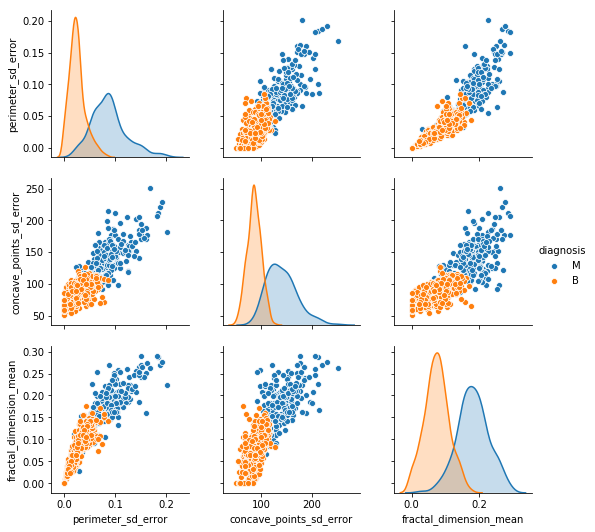

In [509]:
sns.pairplot(df_cancer,hue='diagnosis',vars=x_kbest.columns)

Before moving onto multivariant modelling, note that variables that are highly correlated conveys similar information. Thus, Including only correlated variables may not be ideal from multivariant modelling perspective. In other words, adding fractal_dimension_mean and perimeter_sd_error might not help to further improve the model from having just fractal_dimension_mean or perimeter_sd_error by itself. 

But perhaps we can create a better "reference" axis for multivariable modelling (hence why we do PCA next).

## iii) Modeling

### Build a model to predict the malignant tumors.

We will use two classification techiques, logistic regression (the traditionay way) and random forest decision tree (modern machine learning algorithm). The two techiniques not only differ in their methodology, they also differ in culture. 

A bit of historical and philosophical side note:

The traditional way, like logistic regression, empathesis more on having a correct understanding of how the data enables prediction - a lot of parametric assumptions are used, such as the link function and i.i.d. distribution etc.). The "modern" approach like random forest decision tree mainly aims to minizing cross-validation errors. It leverages on fast computing power to quickly search for the best function to get there. 

However, getting it accurate doesn't mean you have the proper interpretation of the data. For instance, accurate navagation system was developed based on geocentric (earth centered) view even though the underlying theory is incorrect. We are seeing alot of this in image recognition, and hence why there is a need for GAN models.

Thus, although modern model might produce a better fit, the algorithm is a blackbox. In otherwords, we loses interpretability in exhange for accuracy. For more on this, see Leo Breiman, Statistical Modeling: The Two Cultures.

#### Splitting tesing set from training set, so that we can evaluate the performance of each model

In [510]:
#Creating training and testing data set, in order to compare models
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)

### Technique 1: Classifical Logistic Regression

#### Feature engineering (PCA)

Feature engineering - Due to high correlations between variables, PCA is performed to address multi-colinearlity (see the blurb at the end of exploratory analysis section)

The first 10 components forms the "elbow" and explains 95% of the variation. Thus, the first 10 components will be used for logistic regression. 

Theortically, doing this enable us to maximize the information while minize dimensionity and sparsity (i.e., reducing dimension from 30 correlated features to 10 orthogonal components that explains 95% of the variation)

In [511]:
print(X_train.corr()) 

#PCA transform the x feature matrixes into orthogonal components
pca = decomposition.PCA()
x_train_Scaled = X_train.apply(lambda x: scaler(x))
x_train_scaled_pca = pca.fit_transform(x_train_Scaled)
x_test_Scaled = X_test.apply(lambda x: scaler(x))
x_test_scaled_pca = pca.fit_transform(x_test_Scaled)

0                           radius_mean  radius_sd_error  radius_worst  \
0                                                                        
radius_mean                    1.000000         0.327028      0.997826   
radius_sd_error                0.327028         1.000000      0.331623   
radius_worst                   0.997826         0.331623      1.000000   
texture_mean                   0.986516         0.319145      0.985606   
texture_sd_error               0.163964        -0.047148      0.201094   
texture_worst                  0.494905         0.225863      0.546565   
perimeter_mean                 0.664473         0.299119      0.704543   
perimeter_sd_error             0.821811         0.289118      0.850736   
perimeter_worst                0.153565         0.050685      0.190264   
area_mean                     -0.305571        -0.093154     -0.255128   
area_sd_error                  0.701856         0.275679      0.715014   
area_worst                    -0.07707

0.9516540663517947


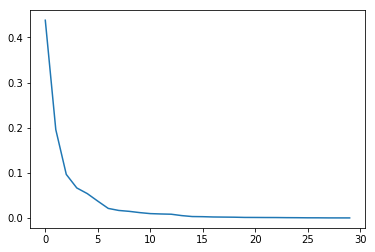

In [656]:
#Determine the number of principle components to include
plt.plot(pca.fit(x_train_Scaled).explained_variance_ratio_)
print(np.sum(pca.fit(x_train_Scaled).explained_variance_ratio_[0:10]))

#### Fitting logistic regression with regularization to control for overfitting
Using the first 10 components as our feature, we fit betas with logistic link function to determine the probability of cancer being malignant or not.

However, a straight out fitting is not ideal because there is a chance that the function might overfit. In other words, the pattern that the function fits to might not generalize, and therefore generating subopitmal error rate in testing set.

One way to address this to use regularization to reduce the influence of variables that carries less information about the class of cancer (y). In this demo, I picked l2 pentalization and tune the hyperparameters using 10 fold cross validation.

In [657]:
LogReg2 = LogisticRegressionCV(solver='saga',max_iter=4000,penalty='l2',cv=10).fit(x_train_scaled_pca[:,0:10],Y_train)

#### Feature importance

The coefficent magnitude measures the unit change in probability of having cancer. Since our PCA are centered and scaled, the coefficent magnitude can be used to determine feature importance. 

However, looking at coefficent magnitude would only help to rank the PCA components. To rank the importance of individual x variables, we have to also consider the PCA loadings. 

Here, the first two principle components is the most important - no suprises here. Within the first component, 'fractal_dimension_worst' appears to be the most important x variable.

In [812]:
#The first two principle components has the highest |coef|
print(abs(LogReg2.coef_))

#Of the variables that goes into the first compoents, fractal_dimension_worst appears to be most important
i_features_PC1 = abs(pca.components_[:,0:1] * np.sqrt(pca.explained_variance_[0:1])).argmax(axis=0)
print(X_train.columns[i_features_PC1])

[[2.86334034 1.68389853 0.75859802 0.42009973 1.35853178 0.55204631
  0.23200008 1.15957167 1.59827281 0.23378886]]
Index(['fractal_dimension_worst'], dtype='object', name=0)


We can combine the coefficent magnitude AND the PCA loadings, and rank the importance of individual x variables. This works because both logstic regression and PCA are both linear transformation.

    Importance_X(i) = sum_p(coef(p)*LoadingFactor(p,i))
    
Here, we see that the top 3 variables are: fractal_dimension_worst, compactness_worst, radius_mean

In [819]:
#Compute and rank individual x features in order of their importance
score_x_features = np.sum(abs(pca.components_[:,0:10] * np.sqrt(pca.explained_variance_[0:10])*LogReg2.coef_),axis=1)
i_features = score_features.argsort(axis=0)[-3:]

#Extract the top three features
X_train.columns[i_features]

Index(['radius_mean', 'compactness_worst', 'fractal_dimension_worst'], dtype='object', name=0)

#### Model performance evaluate

Common way to evaluate classification model is using accuracy score and the confusion matrix.

While accuracy score provides a nice summary statistics to contrast two models, where higher and closer to 100% the better, the confusion matrix provides more details on the inaccurate classifications.

Below is a general definition of the 4 scores outputed by the confusion matrix, taken from https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/:

- true positives (TP): Cases that are correctly predicted to have disease
- true negatives (TN): Cases that are correctly predicted to have no disease
- false positives (FP): We predicted yes, but they don't actually have the disease.
- false negatives (FN): We predicted no, but they actually do have the disease.


In [676]:
c_matrix_log = confusion_matrix(LogReg2.predict(x_test_scaled_pca[:,0:10]),Y_test)
a_score_log = accuracy_score(LogReg2.predict(x_test_scaled_pca[:,0:10]),Y_test)

print(['tn, fp, fn, tp: '+str(c_matrix_log.ravel())])
print(['accuracy for testing set: '+str(a_score_log)])

['tn, fp, fn, tp: [67  3  2 42]']
['accuracy for testing set: 0.956140350877193']


### Technique 2: Random forest


#### Hyperparameter tuning using gridsearch

Compare to logistic regression, random forest have more hyperparameters to tune and thus requires more resources/time to train. 

These hyperparameters also provide the model with more flexiablity, and thus we don't need to worry as much about feature engineering. Plus it is a non-linear decision trees, and thus could handle multicollinearity issue slightly better than the linear logistic approach. 

Hence we aren't going to focus too much on feature engineering, but rather let's spend time on hyperparameter tunning using gridsearch cross-validation.

In [679]:
#Initialize the hyperparameters to try, and using 5-fold cross-validation to find the most optimial combinations.
#Due to time constrain, we only look at a selective set of possible hyperparameters
param_grid = { 'n_estimators': [100, 500, 900],
              'max_features': ['auto', 'sqrt'],
              'max_depth': [10, 50, 100, None],}
rfc=RandomForestClassifier(random_state=0)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, Y_train)

#Display the best parameters
print(CV_rfc.best_params_)

{'max_depth': 10, 'max_features': 'auto', 'n_estimators': 500}

#### Random forest decision tree fitting

Once we found our optimal hyperparameters, we can then input them into our random forest algorithm and construct our model. 

Briefly, random forest works by building many many decision trees (n_estimators determines the number of trees). Each tree is trained on an sightly different set of data, and take a "vote" on whether the tumor is malignant or not. At the end, the model will decide the class for that tumor based on majority's pick.

In [681]:
rfc_best = RandomForestClassifier(random_state=0,n_estimators=500,max_features='auto',max_depth=10)
rfc_best.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Feature importance

Because random forest models are a collection of small models (i.e., emsemble method), the importance of the feature are determined by two things:
1. probablity of that feature to be selected by each model 
2. impact of that feature on improving the fit if selected.

Here, the top three features identified to be important under random forest are: concave_points_sd_error, fractal_dimension_mean, concavity_worst.

In [821]:
i_rfc_topfs = rfc_best.feature_importances_.argsort()[-3:]
X_train.columns[i_rfc_topfs]

Index(['concavity_worst', 'fractal_dimension_mean', 'concave_points_sd_error'], dtype='object', name=0)

#### Model performance

Using the same set up as logistic regression, we can now compare the two results. 

Interestingly, both logistic and random forest models produce very similar accuracy.

In [822]:
#Model performance for random forest model on testing dataset

c_matrix_rf = confusion_matrix(rfc_best.predict(X_test),Y_test)
a_score_rf = accuracy_score(rfc_best.predict(X_test),Y_test)

print(['tn, fp, fn, tp: '+str(c_matrix_rf.ravel())])
print(['accuracy for testing set: '+str(a_score_rf)])

['tn, fp, fn, tp: [68  4  1 41]']
['accuracy for testing set: 0.956140350877193']


In [823]:
#Compare to the logistic model on testing dataset
print(['tn, fp, fn, tp: '+str(c_matrix_log.ravel())])
print(['accuracy for testing set: '+str(a_score_log)])

['tn, fp, fn, tp: [67  3  2 42]']
['accuracy for testing set: 0.956140350877193']


## iv) Explanation

#### Technical Audiences: Explain the limitations of your analysis and identify possible further steps you could take

1. The lack of metadata and methodology

Start from the data, one of the limitation is not having a full set of metadata to help understand the features. As well as how the variables are collected. These insights are important in forming an idea on how to engineer features, and how to interpret the results. 

Another concern is whether or not the sample is biased. A common issue in health care is that, western studies are done for patients who are predominately caucasian. Thus, the results does not generalize well to patients of different ethnicity.

2. Switch to a multivariable non-parameteric outlier detection method

Each column are scaled, and z score > 3 within each column are identified as outliers. This approach has the following limitaitons:
- This method does not consider the  correlation between columns. A better approach would be using machine learning cluster analysis like DBScan.
- Multiple comparsion problem, as column size increases. In other words, we have a high chance of false positives as we increase the number of columns. Again a high dimensional cluster approach would work better.
- z score assumes a normal distribution of the data and does not work well with skewed data. There's likely some columns that does not meet the normal distribution assumption. Thus, a non-parameteric clustering approach would work better.

If time allows, I would investigate using DBScan to detect outliers.

3. Improve hyperparameter searching space and speed using genetic algorithm

Hyperparameter training for machine learning algorithms like random forest can be very expensive. Gridsearch is an exhaustive search function, and this function becomes very expensive when we start to increase the number of hyperparameters (e.g., NP-complete).

A faster and more efficent way to solve this problem would be to apply genetic algorithm. This type of algorithm is designed to solve these NP problems, and hae shown success.

Switching from gridsearch to genetic algorithm could help to improve model performance for random forest but finding a more optimal set of hyperparameters.


4. Power analysis to determine where we lack data

Machine learning algorithm tends to out perform traditional methods when we have large amount of data, and feature space. My gut feeling is that with 30 different features, the data might be too sparse and there could be improvements made by increasing sample size. Power analysis could be employed to further answer this question.






#### Non-Technical Audiences: Write a short summary of your analysis, explaining how your model works and how it performs.

We can see that dataset contains enough information to accurately predict whether tumors are maligant or benign.

We first saw this in our explortary analysis, where we can see visually see a clear separation in features like fractal_dimension_mean for tumors that are magligant and benign. Using multivariant models (logistic and random forest), we are able to accurately predict correct cases at approximately 95% accuracy level. Although both models gave very similar results, what's under the hood is slightly different.

Briefly, logistic regression is a traditional method used for classification. Under this method, model predicts the probability of tumors being maligant. The impact of each feature in determining that prediction can be directly determined by looking at the betas. Random forest also predicts the probability of tumor being magligant. It does so by constructing many set of models using data sets that are slightly different. Probablity of tumor being magligant are estimated based on percentage of votes from each model - much like democratic election, if 80/100 of the votes think the tumor is magligant then the probalbity of it being magligant is 80%. However, the impact of each variable on the predict is not clear. Hence why it is sometimes called a "black-box".

The variable fractal_dimension kept showing up as an important feature. Under logistic regression, fractal_dimension_worst is one of the top important variables and under random forest, fractal_dimension_mean was identified as one of the top 3.

A quick google search shows that fractal dimension seems to be measuring the describe the irregular shapes, and it is one of the criteras used to identify breast cancer (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6349609/). This supports our findings.